In [1]:
# In this script we want to determine the contribution of each pathway on stacked trimer assembly
# Name: Leo Lagunes and Paige M.
# Date: 10/17/22 

# Last update: 1/06/24 

# IMPORTANT NOTE: The equations were written and developed by Drs. Eric Deeds and Koan Briggs, this code was developed by LL 

# Running in python 

# -----------------------------
# --- Current outline --- 
# -----------------------------

# 1. Start with 2 pathways
# 2. Define the pathway as a tree 
# 3. Calculate the contribution of that pathway 
# 4. Plot the contribution of each pathway 


# NOTES: 
# Here are the cutoffs for the final step in the stacked trimer assembly: 
# x_9+x_9: 1
# x_6+x_6: 2-4
# x_4+x_4: 5-7
# x_10+x_3: 8-13
# x_8 + x_2: 14-19
# x_11+x_1: 20-46

In [1]:
# ---------------------------------------------------
# --- packages to use ---
# ---------------------------------------------------

# First we need to import all of the packages we will be using!",
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
import seaborn as sns # for the heatmaps
from datetime import date # to print date
from datetime import datetime
from matplotlib.ticker import LogLocator
import matplotlib

import matplotlib.patches as patches # for rectangle plots


# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%m/%d/%Y %I:%M %p")

print('All packages loaded on ', dt_string)

All packages loaded on  11/30/2022 11:22 AM


In [2]:
# ---------------------------------------------------
# --- Simple pathway example (dictionary) ---
# --------------------------------------------------- 
# --- Today --- 
today_pre = date.today()
today = today_pre.strftime("%m_%d_%y")

# ---------------------------------------------------
# --- functions to use ---
# --------------------------------------------------- 

# ---------------------------------------------------
# --- Calculate the n_ways ---   
# ---------------------------------------------------
def calc_n_ways(rxnStr,listOfAllRxns):
    # this function determines the n_ways coefficient which represents the Association reaction equivalence class cardinality
    productR=rxnStr[0];reactantsR = rxnStr[1:3]; # product and reactants in this reaction (string)
    # re-order the list to match the order in the full list
    list_search = [reactantsR[0],reactantsR[1],productR]
    #print('listCheck',list_search)
    #check that this list in the full list 
    for listI_all in listOfAllRxns: #for all the rxns, check that the rxn of interest is a subset of those
        A=list_search;B=listI_all;        
        if(set(A).issubset(set(B))):
            n_ways = B[3]; # n_ways.append(n_ways_add)
            #print('Nways= ', n_ways)  
    return n_ways

# --------------------------------------------------------
# --- Calculate pathway contributions and rxn fluxes ---   
# --------------------------------------------------------

def calcFluxOnePath(pathway,listOfAllRxns):
    # This function calculates the reaction fluxes for one pathway
    fluxTotMat = []
    for rxn_ind in range(0,4): # number of rxns in one pathways #3????
        rxn=pathway["rxns"][rxn_ind] #rxn concentration value
        rxnStr = pathway["pathwayNodes"][rxn_ind]; # rxn string
        #print(rxnStr)
        productR=rxn[0];reactantsR = rxn[1:3]; # product and reactants in this reaction
        #print("reaction: " , rxn); print("reactants: " , reactantsR); print("product: " , productR)
        # --- flux of this reaction ---
        n_waysVal = calc_n_ways(rxnStr,listOfAllRxns);#print("nways: ", n_waysVal)
        flux=n_waysVal*kOn*np.product(reactantsR); fluxAdd = [rxnStr[0], flux]
        #print(fluxAdd)
        fluxTotMat.append(fluxAdd) # represents the flux for making species xi from the pathway 
    return fluxTotMat
    
def findTotalFlux_species(elem_to_find,listFluxTot):
    # This function returns the total flux for a specific species
    ini_list=listFluxTot
    for sublist in ini_list:
    #print('sublist: ', sublist)
        if(elem_to_find in sublist):
            # extract the total flux
            totFlux_species = sublist[1]
            #print("total flux: ", totFlux_species)
    return totFlux_species


def calcFHat_path(pathway_rxnFlux,totalFluxes):
    # This function calculates F^ for one pathway
    fHatAll=[]
    for rxn_ind in range(0,3): # for each reaction calc F^
        # -- gather species and rxn fluxes ---
        species = pathway_rxnFlux[rxn_ind][0]; rxnFlux = pathway_rxnFlux[rxn_ind][1]
        #print("species: ", species)
        # --- total flux for that species ---
        listNames = totalFluxes.get("species"); listFluxTot = totalFluxes.get("flux")
        elem_to_find=species;
        totFlux_species_i=findTotalFlux_species(elem_to_find,listFluxTot)
        # --- calculate F^ ---
        f_hat_species = rxnFlux/totFlux_species_i
        #print("rxn flux: ", rxnFlux)
        fHatAll.append(f_hat_species)
        # print("F^: ", f_hat_species)
    fHat_path = np.product(fHatAll)
    return fHat_path


def calcPathContribution(listOfPathways,totalFluxes,listOfAllRxns):
    # This function loops over the list of pathways and returns the pathway contributions
    pathwayContris=[]
    for pathway in listOfPathways:
        #print("Pathway: ", pathway)
        # --- calculate all rxn flux ---
        pathway1_rxnFlux = calcFluxOnePath(pathway,listOfAllRxns)
        # --- calculate the contribution of the pathway ---
        # This is the product of the rxn fluxes that make up the pathway 
        FHat_1=calcFHat_path(pathway1_rxnFlux,totalFluxes)
        pathwayContris.append(FHat_1)
        #print(FHat_1)    
    return pathwayContris





# ---------------------------------------------------
# --- EJD Eqns for stacked trimer ---   
# ---------------------------------------------------
def keff(i,j):
    # calculate the k_effective value given the i,j indices and the kd's (binding affinities)
    ℯ = math.e
    #kd1 = kds[0]; kd2 = kds[1]
    keff= kOn*(kd1**i)*(kd2**j)*ℯ**(-(i+j-1)*9/0.6)
    
    return keff

def stackedTrimer(states, t):
    #x0Val = paramvaluesList[0] # initial condition for x1 
    x = states
    # list of ode's
    dx_0 = - 2*kOn*0.5*x[0]*x[0] + 1*keff(1,0)*x[1] - 2*kOn*0.5*x[0]*x[0] + 1*keff(1,0)*x[1] - 1*kOn*0.5*x[0]*x[0] + 1*keff(0,1)*x[2] - 1*kOn*0.5*x[0]*x[0] + 1*keff(0,1)*x[2] - 1*kOn*1*x[0]*x[1] + 3*keff(2,0)*x[3] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[4] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[5] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[5] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[4] - 3*kOn*1*x[0]*x[3] + 1*keff(0,1)*x[6] - 1*kOn*1*x[0]*x[4] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[4] + 2*keff(1,0)*x[7] - 1*kOn*1*x[0]*x[4] + 2*keff(1,1)*x[8] - 1*kOn*1*x[0]*x[5] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[5] + 2*keff(1,1)*x[8] - 1*kOn*1*x[0]*x[5] + 2*keff(1,0)*x[9] - 2*kOn*1*x[0]*x[6] + 2*keff(1,1)*x[10] - 2*kOn*1*x[0]*x[7] + 1*keff(2,1)*x[10] - 2*kOn*1*x[0]*x[8] + 1*keff(2,0)*x[10] - 2*kOn*1*x[0]*x[9] + 1*keff(2,1)*x[10] - 1*kOn*1*x[0]*x[10] + 6*keff(2,1)*x[11] + Q - δ*x[0] 
    dx_1 = + 2*kOn*0.5*x[0]*x[0] - 1*keff(1,0)*x[1] - 1*kOn*1*x[0]*x[1] + 3*keff(2,0)*x[3] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[4] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[5] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,2)*x[8] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,2)*x[8] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[9] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[9] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[7] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[7] - 2*kOn*1*x[1]*x[2] + 1*keff(2,0)*x[6] - 3*kOn*1*x[1]*x[3] + 1*keff(0,2)*x[10] - 1*kOn*1*x[1]*x[4] + 1*keff(2,1)*x[10] - 1*kOn*1*x[1]*x[5] + 1*keff(2,1)*x[10] - 1*kOn*1*x[1]*x[6] + 6*keff(2,2)*x[11]  -  δ*x[1]
    dx_2 = + 1*kOn*0.5*x[0]*x[0] - 1*keff(0,1)*x[2] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[5] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[4] - 2*kOn*1*x[1]*x[2] + 1*keff(2,0)*x[6] - 4*kOn*0.5*x[2]*x[2] + 1*keff(2,0)*x[8] - 4*kOn*0.5*x[2]*x[2] + 1*keff(2,0)*x[8] - 2*kOn*1*x[2]*x[4] + 1*keff(3,0)*x[10] - 2*kOn*1*x[2]*x[5] + 1*keff(3,0)*x[10] - 2*kOn*1*x[2]*x[8] + 3*keff(4,0)*x[11]  - δ*x[2]
    dx_3 = + 1*kOn*1*x[0]*x[1] - 3*keff(2,0)*x[3] - 3*kOn*1*x[0]*x[3] + 1*keff(0,1)*x[6] - 3*kOn*1*x[1]*x[3] + 1*keff(0,2)*x[10] - 3*kOn*0.5*x[3]*x[3] + 1*keff(0,3)*x[11] - 3*kOn*0.5*x[3]*x[3] + 1*keff(0,3)*x[11]  - δ*x[3]
    dx_4 = + 1*kOn*1*x[0]*x[1] - 1*keff(0,1)*x[4] + 2*kOn*1*x[0]*x[2] - 1*keff(1,0)*x[4] - 1*kOn*1*x[0]*x[4] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[4] + 2*keff(1,0)*x[7] - 1*kOn*1*x[0]*x[4] + 2*keff(1,1)*x[8] - 1*kOn*1*x[1]*x[4] + 1*keff(2,1)*x[10] - 2*kOn*1*x[2]*x[4] + 1*keff(3,0)*x[10] - 1*kOn*0.5*x[4]*x[4] + 3*keff(4,1)*x[11] - 1*kOn*0.5*x[4]*x[4] + 3*keff(4,1)*x[11]  - δ*x[4]
    dx_5 = + 1*kOn*1*x[0]*x[1] - 1*keff(0,1)*x[5] + 2*kOn*1*x[0]*x[2] - 1*keff(1,0)*x[5] - 1*kOn*1*x[0]*x[5] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[5] + 2*keff(1,1)*x[8] - 1*kOn*1*x[0]*x[5] + 2*keff(1,0)*x[9] - 1*kOn*1*x[1]*x[5] + 1*keff(2,1)*x[10] - 2*kOn*1*x[2]*x[5] + 1*keff(3,0)*x[10] - 1*kOn*0.5*x[5]*x[5] + 3*keff(4,1)*x[11] - 1*kOn*0.5*x[5]*x[5] + 3*keff(4,1)*x[11]  - δ*x[5]
    dx_6 = + 3*kOn*1*x[0]*x[3] - 1*keff(0,1)*x[6] + 1*kOn*1*x[0]*x[4] - 1*keff(2,0)*x[6] + 1*kOn*1*x[0]*x[5] - 1*keff(2,0)*x[6] - 2*kOn*1*x[0]*x[6] + 2*keff(1,1)*x[10] + 2*kOn*1*x[1]*x[2] - 1*keff(2,0)*x[6] - 1*kOn*1*x[1]*x[6] + 6*keff(2,2)*x[11]  - δ*x[6]
    dx_7 = + 1*kOn*1*x[0]*x[4] - 2*keff(1,0)*x[7] - 2*kOn*1*x[0]*x[7] + 1*keff(2,1)*x[10] + 1*kOn*0.5*x[1]*x[1] - 1*keff(0,1)*x[7]  - δ*x[7]
    dx_8 = + 1*kOn*1*x[0]*x[4] - 2*keff(1,1)*x[8] + 1*kOn*1*x[0]*x[5] - 2*keff(1,1)*x[8] - 2*kOn*1*x[0]*x[8] + 1*keff(2,0)*x[10] + 1*kOn*0.5*x[1]*x[1] - 1*keff(0,2)*x[8] + 4*kOn*0.5*x[2]*x[2] - 1*keff(2,0)*x[8] - 2*kOn*1*x[2]*x[8] + 3*keff(4,0)*x[11]  - δ*x[8]
    dx_9 = + 1*kOn*1*x[0]*x[5] - 2*keff(1,0)*x[9] - 2*kOn*1*x[0]*x[9] + 1*keff(2,1)*x[10] + 1*kOn*0.5*x[1]*x[1] - 1*keff(0,1)*x[9]  - δ*x[9]
    dx_10 = + 2*kOn*1*x[0]*x[6] - 2*keff(1,1)*x[10] + 2*kOn*1*x[0]*x[7] - 1*keff(2,1)*x[10] + 2*kOn*1*x[0]*x[8] - 1*keff(2,0)*x[10] + 2*kOn*1*x[0]*x[9] - 1*keff(2,1)*x[10] - 1*kOn*1*x[0]*x[10] + 6*keff(2,1)*x[11] + 3*kOn*1*x[1]*x[3] - 1*keff(0,2)*x[10] + 1*kOn*1*x[1]*x[4] - 1*keff(2,1)*x[10] + 1*kOn*1*x[1]*x[5] - 1*keff(2,1)*x[10] + 2*kOn*1*x[2]*x[4] - 1*keff(3,0)*x[10] + 2*kOn*1*x[2]*x[5] - 1*keff(3,0)*x[10]  - δ*x[10]
    dx_11 = + 1*kOn*1*x[0]*x[10] - 6*keff(2,1)*x[11] + 1*kOn*1*x[1]*x[6] - 6*keff(2,2)*x[11] + 2*kOn*1*x[2]*x[8] - 3*keff(4,0)*x[11] + 3*kOn*0.5*x[3]*x[3] - 1*keff(0,3)*x[11] + 1*kOn*0.5*x[4]*x[4] - 3*keff(4,1)*x[11] + 1*kOn*0.5*x[5]*x[5] - 3*keff(4,1)*x[11]  - δ*x[11]
   
    states_prime = [dx_0, dx_1,dx_2,dx_3,dx_4, dx_5, dx_6,dx_7,dx_8,dx_9,dx_10,dx_11]
    
    return states_prime 
 
# ---------------------------------------------------
# --- Assembly Yield --- 
# ---------------------------------------------------
def calcAY24hrs(IC_1,XnTimePtsVec):
    # this function calculates the assembly yield for a time course of one species
    n=6; Xn = XnTimePtsVec;
    # --- calculate XT --- 
    # define XT as the IC of monomers (predefined)
    XT = IC_1; # print(XT)
    # --- calculate Yn ---
    Yn = n*Xn/XT;
    
    return Yn


# -----------------------------------------------------------
now = datetime.now(); dt_string = now.strftime("%m/%d/%Y %I:%M %p")
print('All functions ready on', dt_string)

All functions ready on 11/30/2022 11:22 AM


In [3]:
# ---------------------------------------------------
# --- List of pathways --- 
# ---------------------------------------------------
def getPathways(solution_1):
    # This function defines the pathways based on the species concentrations slns
    # define each species 
    x_1 = solution_1[-1,0]; x_2 = solution_1[-1,2]; x_3 = solution_1[-1,1];
    x_4 = solution_1[-1,5]; x_5 = solution_1[-1,9]; x_6 = solution_1[-1,4];
    x_7 = solution_1[-1,7]; x_8 = solution_1[-1,8]; x_9 = solution_1[-1,3];
    x_10 = solution_1[-1,6]; x_11 = solution_1[-1,10]; x_12 = solution_1[-1,11];
    # --- Define pathways in a dictionary --- 
    # definitions are in a top-down fashion and left to right. 
    # Each list represents a reaction as ['product', 'reactant 1', 'reactant 2']
    pathway_1 ={ "pathwayNodes": [['x_12','x_9','x_9'], ['x_9','x_3','x_1'],['x_9','x_3','x_1'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_9,x_9], [x_9,x_3,x_1],[x_9,x_3,x_1],[x_3,x_1,x_1],[x_3,x_1,x_1]] }

    pathway_2 ={"pathwayNodes": [ ['x_12','x_6','x_6'],['x_6','x_3','x_1'],['x_6','x_3','x_1'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_6,x_6],[x_6,x_3,x_1],[x_6,x_3,x_1],[x_3,x_1,x_1],[x_3,x_1,x_1]] }

    pathway_3 ={"pathwayNodes": [ ['x_12','x_6','x_6'],['x_6','x_2','x_1'],['x_6','x_3','x_1'],['x_2','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_6,x_6],[x_6,x_2,x_1],[x_6,x_3,x_1],[x_2,x_1,x_1],[x_3,x_1,x_1]] }

    pathway_4 ={"pathwayNodes": [ ['x_12','x_6','x_6'],['x_6','x_2','x_1'],['x_6','x_2','x_1'],['x_2','x_1','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [[x_12,x_6,x_6],[x_6,x_2,x_1],[x_6,x_2,x_1],[x_2,x_1,x_1],[x_2,x_1,x_1]] }

    pathway_5 ={"pathwayNodes": [ ['x_12','x_4','x_4'],['x_4','x_3','x_1'],['x_4','x_3','x_1'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_4,x_4],[x_4,x_3,x_1],[x_4,x_3,x_1],[x_3,x_1,x_1],[x_3,x_1,x_1]] }

    pathway_6 ={"pathwayNodes": [ ['x_12','x_4','x_4'],['x_4','x_2','x_1'],['x_4','x_3','x_1'],['x_2','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_4,x_4],[x_4,x_2,x_1],[x_4,x_3,x_1],[x_2,x_1,x_1],[x_3,x_1,x_1]] }

    pathway_7 ={"pathwayNodes": [ ['x_12','x_4','x_4'],['x_4','x_2','x_1'],['x_4','x_2','x_1'],['x_2','x_1','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [[x_12,x_4,x_4],[x_4,x_2,x_1],[x_4,x_2,x_1],[x_2,x_1,x_1],[x_2,x_1,x_1]] }

    pathway_8 ={"pathwayNodes": [ ['x_12','x_10','x_3'],['x_10','x_2','x_3'],['x_3','x_1','x_1'],['x_2','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_10,x_3],[x_10,x_2,x_1],[x_3,x_1,x_1],[x_2,x_1,x_1],[x_3,x_1,x_1]] }

    pathway_9 ={"pathwayNodes": [ ['x_12','x_10','x_3'],['x_10','x_9','x_1'],['x_3','x_1','x_1'],['x_9','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_10,x_3],[x_10,x_9,x_1],[x_3,x_1,x_1],[x_9,x_3,x_1],[x_3,x_1,x_1]] }

    pathway_10 ={"pathwayNodes": [ ['x_12','x_10','x_3'],['x_10','x_6','x_1'],['x_3','x_1','x_1'],['x_6','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_10,x_3],[x_10,x_6,x_1],[x_3,x_1,x_1],[x_6,x_3,x_1],[x_3,x_1,x_1]] }

    pathway_11 ={"pathwayNodes": [ ['x_12','x_10','x_3'],['x_10','x_6','x_1'],['x_3','x_1','x_1'],['x_6','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [[x_12,x_10,x_3],[x_10,x_6,x_1],[x_3,x_1,x_1],[x_6,x_2,x_1],[x_2,x_1,x_1]] }

    pathway_12 ={"pathwayNodes": [ ['x_12','x_10','x_3'],['x_10','x_4','x_1'],['x_3','x_1','x_1'],['x_4','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_10,x_3],[x_10,x_4,x_1],[x_3,x_1,x_1],[x_4,x_3,x_1],[x_3,x_1,x_1]] }

    pathway_13 ={"pathwayNodes": [ ['x_12','x_10','x_3'],['x_10','x_4','x_1'],['x_3','x_1','x_1'],['x_4','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [[x_12,x_10,x_3],[x_10,x_4,x_1],[x_3,x_1,x_1],[x_4,x_2,x_1],[x_2,x_1,x_1]] }

    pathway_14 ={"pathwayNodes": [ ['x_12','x_8','x_2'],['x_8','x_3','x_3'],['x_2','x_1','x_1'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [[x_12,x_8,x_2],[x_8,x_3,x_3],[x_2,x_1,x_1],[x_3,x_1,x_1],[x_3,x_1,x_1]] }

    pathway_15 ={"pathwayNodes": [ ['x_12','x_8','x_2'],['x_8','x_2','x_2'],['x_2','x_1','x_1'],['x_2','x_1','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [[x_12,x_8,x_2],[x_8,x_2,x_2],[x_2,x_1,x_1],[x_2,x_1,x_1],[x_2,x_1,x_1]] }

    pathway_16 ={"pathwayNodes": [ ['x_12','x_8','x_2'],['x_8','x_6','x_1'],['x_2','x_1','x_1'],['x_6','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_8,x_2],[x_8,x_6,x_1],[x_2,x_1,x_1],[x_6,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_17 ={"pathwayNodes": [ ['x_12','x_8','x_2'],['x_8','x_6','x_1'],['x_2','x_1','x_1'],['x_6','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_8,x_2],[x_8,x_6,x_1],[x_2,x_1,x_1],[x_6,x_2,x_1],[x_2,x_1,x_1] ] }

    pathway_18 ={"pathwayNodes": [ ['x_12','x_8','x_2'],['x_8','x_4','x_1'],['x_2','x_1','x_1'],['x_4','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_8,x_2],[x_8,x_4,x_1],[x_2,x_1,x_1],[x_4,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_19 ={"pathwayNodes": [ ['x_12','x_8','x_2'],['x_8','x_4','x_1'],['x_2','x_1','x_1'],['x_4','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_8,x_2],[x_8,x_4,x_1],[x_2,x_1,x_1],[x_4,x_2,x_1],[x_2,x_1,x_1] ] }

    pathway_20 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_9','x_3'],['x_9','x_3','x_1'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_9,x_3],[x_9,x_3,x_1],[x_3,x_1,x_1],[x_3,x_1,x_1] ] }

    pathway_21 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_6','x_3'],['x_6','x_3','x_1'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_6,x_3],[x_6,x_3,x_1],[x_3,x_1,x_1],[x_3,x_1,x_1] ] }

    pathway_22 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_6','x_3'],['x_6','x_2','x_1'],['x_3','x_1','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_6,x_3],[x_6,x_2,x_1],[x_3,x_1,x_1],[x_2,x_1,x_1] ] }

    pathway_23 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_3','x_4'],['x_3','x_1','x_1'],['x_4','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_3,x_4],[x_3,x_1,x_1],[x_4,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_24 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_3','x_4'],['x_3','x_1','x_1'],['x_4','x_1','x_2'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_3,x_4],[x_3,x_1,x_1],[x_4,x_1,x_2],[x_2,x_1,x_1] ] }

    pathway_25 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_6','x_2'],['x_6','x_3','x_1'],['x_2','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_6,x_2],[x_6,x_3,x_1],[x_2,x_1,x_1],[x_3,x_1,x_1] ] }

    pathway_26 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_6','x_2'],['x_6','x_2','x_1'],['x_2','x_1','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_6,x_2],[x_6,x_2,x_1],[x_2,x_1,x_1],[x_2,x_1,x_1] ] }

    pathway_27 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_2','x_4'],['x_2','x_1','x_1'],['x_4','x_1','x_3'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_2,x_4],[x_2,x_1,x_1],[x_4,x_1,x_3],[x_3,x_1,x_1] ] }

    pathway_28 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_2','x_4'],['x_2','x_1','x_1'],['x_4','x_1','x_2'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_2,x_4],[x_2,x_1,x_1],[x_4,x_1,x_2],[x_2,x_1,x_1] ] }

    pathway_29 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_10','x_1'],['x_10','x_2','x_3'],['x_2','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_10,x_1],[x_10,x_2,x_3],[x_2,x_1,x_1],[x_3,x_1,x_1] ] }

    pathway_30 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_10','x_1'],['x_10','x_9','x_1'],['x_9','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_10,x_1],[x_10,x_9,x_1],[x_9,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_31 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_10','x_1'],['x_10','x_6','x_1'],['x_6','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_10,x_1],[x_10,x_6,x_1],[x_6,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_32 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_10','x_1'],['x_10','x_6','x_1'],['x_6','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_10,x_1],[x_10,x_6,x_1],[x_6,x_2,x_1],[x_2,x_1,x_1] ] }

    pathway_33 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_10','x_1'],['x_10','x_4','x_1'],['x_4','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_10,x_1],[x_10,x_4,x_1],[x_4,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_34 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_10','x_1'],['x_10','x_4','x_1'],['x_4','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_10,x_1],[x_10,x_4,x_1],[x_4,x_2,x_1],[x_2,x_1,x_1] ] }

    pathway_35 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_8','x_1'],['x_8','x_3','x_3'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_8,x_1],[x_8,x_3,x_3],[x_3,x_1,x_1],[x_3,x_1,x_1] ] }

    pathway_36 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_8','x_1'],['x_8','x_2','x_2'],['x_2','x_1','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_8,x_1],[x_8,x_2,x_2],[x_2,x_1,x_1],[x_2,x_1,x_1] ] }

    pathway_37 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_8','x_1'],['x_8','x_6','x_1'],['x_6','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_8,x_1],[x_8,x_6,x_1],[x_6,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_38 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_8','x_1'],['x_8','x_6','x_1'],['x_6','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_8,x_1],[x_8,x_6,x_1],[x_6,x_2,x_1],[x_2,x_1,x_1] ] }

    pathway_39 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_8','x_1'],['x_8','x_4','x_1'],['x_4','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_8,x_1],[x_8,x_4,x_1],[x_4,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_40 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_8','x_1'],['x_8','x_4','x_1'],['x_4','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_8,x_1],[x_8,x_4,x_1],[x_4,x_2,x_1],[x_2,x_1,x_1] ] }

    pathway_41 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_7','x_1'],['x_7','x_3','x_3'],['x_2','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_7,x_1],[x_7,x_3,x_3],[x_2,x_1,x_1],[x_3,x_1,x_1] ] }

    pathway_42 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_7','x_1'],['x_7','x_6','x_1'],['x_6','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_7,x_1],[x_7,x_6,x_1],[x_6,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_43 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_7','x_1'],['x_7','x_6','x_1'],['x_6','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_7,x_1],[x_7,x_6,x_1],[x_6,x_2,x_1],[x_2,x_1,x_1] ] }

    pathway_44 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_5','x_1'],['x_5','x_3','x_3'],['x_3','x_1','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_5,x_1],[x_5,x_3,x_3],[x_3,x_1,x_1],[x_3,x_1,x_1] ] }

    pathway_45 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_5','x_1'],['x_5','x_4','x_1'],['x_4','x_3','x_1'],['x_3','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_5,x_1],[x_5,x_4,x_1],[x_4,x_3,x_1],[x_3,x_1,x_1] ] }

    pathway_46 ={"pathwayNodes": [ ['x_12','x_11','x_1'],['x_11','x_5','x_1'],['x_5','x_4','x_1'],['x_4','x_2','x_1'],['x_2','x_1','x_1'] ],
                 "rxns": [ [x_12,x_11,x_1],[x_11,x_5,x_1],[x_5,x_4,x_1],[x_4,x_2,x_1],[x_2,x_1,x_1] ] }

    # make a list of all the pathways (to loop over them in a function)
    listOfPathways = [pathway_1,pathway_2,pathway_3, pathway_4,pathway_5,pathway_6,
                  pathway_7,pathway_8,pathway_9,pathway_10,pathway_11,pathway_12,
                  pathway_13,pathway_14,pathway_15,pathway_16,pathway_17,pathway_18,
                  pathway_19,pathway_20,pathway_21,pathway_22,pathway_23,pathway_24,
                  pathway_25,pathway_26,pathway_27,pathway_28,pathway_29,pathway_30,
                  pathway_31,pathway_32,pathway_33,pathway_34,pathway_35,pathway_36,
                  pathway_37,pathway_38,pathway_39,pathway_40,pathway_41,pathway_42,
                  pathway_43,pathway_44,pathway_45,pathway_46]
    
    # --- Define the total flux for each species --- 
    totalFluxes = {"species": ['x_12','x_11','x_10','x_9','x_8', 'x_7','x_6','x_5','x_4','x_3','x_2','x_1'],
              "flux": [['x_12',  1*kOn*1*x_1*x_11 + 1*kOn*1*x_3*x_10  + 2*kOn*1*x_2*x_8  + 3*kOn*0.5*x_9*x_9 + 1*kOn*0.5*x_6*x_6  + 1*kOn*0.5*x_4*x_4  ], 
                       ['x_11', 2*kOn*1*x_1*x_10  + 2*kOn*1*x_1*x_7  + 2*kOn*1*x_1*x_8  + 2*kOn*1*x_1*x_5 + 3*kOn*1*x_3*x_9  + 1*kOn*1*x_3*x_6  + 1*kOn*1*x_3*x_4 + 2*kOn*1*x_2*x_6  + 2*kOn*1*x_2*x_4  ], 
                       ['x_10', 1*kOn*1*x_1*x_9  + 1*kOn*1*x_1*x_6 + 1*kOn*1*x_3*x_2  ], 
                       ['x_9',  1*kOn*1*x_1*x_3 ],
                       ['x_8',  1*kOn*1*x_1*x_6 + 1*kOn*1*x_1*x_4  + 1*kOn*x_3*x_3  + 1*kOn*x_2*x_2    ], 
                       ['x_7', 1*kOn*1*x_1*x_6  + 1*kOn*x_3*x_3  ],                       
                       ['x_6', 1*kOn*1*x_1*x_3 + 1*kOn*1*x_1*x_2 ], # 1*kOn*1*x_1*x_3  
                       ['x_5', 1*kOn*1*x_1*x_4   + 1*kOn*0.5*x_3*x_3 ], 
                       ['x_4', 1*kOn*1*x_1*x_3  + 1*kOn*1*x_1*x_2 ],
                       ['x_3', 2*kOn*0.5*x_1*x_1  ],
                       ['x_2', 2*kOn*0.5*x_1*x_1 ], #  1*kOn*0.5*x_1*x_1                     
                       ['x_1', 1]]
                    }
    # ---- Define all the rxns ---
    listOfAllRxns = [['x_1','x_1','x_3',2],['x_1','x_1','x_2',1],['x_1','x_3','x_9',1],
                 ['x_1','x_3','x_6',1],['x_1','x_3','x_4',1],['x_1','x_2','x_4',2],
                 ['x_1','x_2','x_6',2],['x_1','x_9','x_10',3],['x_1','x_6','x_10',1],
                 ['x_1','x_6','x_7',1],['x_1','x_6','x_8',1],['x_1','x_4','x_10',1],
                 ['x_1','x_4','x_8',1],['x_1','x_4','x_5',1],['x_1','x_10','x_11',2],
                 ['x_1','x_7','x_11',2],['x_1','x_8','x_11',2],['x_1','x_5','x_11',2],
                 ['x_1','x_11','x_12',1],['x_3','x_3','x_8',1],['x_3','x_3','x_5',1],
                 ['x_3','x_3','x_7',1],['x_3','x_2','x_10',2],['x_3','x_9','x_11',3],
                 ['x_3','x_6','x_11',1],['x_3','x_4','x_11',1],['x_3','x_10','x_12',1],
                 ['x_2','x_2','x_8',4],['x_2','x_6','x_11',2],['x_2','x_4','x_11',2],
                 ['x_2','x_8','x_12',2],['x_9','x_9','x_12',3],['x_6','x_6','x_12',1],
                 ['x_4','x_4','x_12',1]]
    
    return listOfPathways,totalFluxes,listOfAllRxns

Working on pathway analysis WITH synth/deg...
ODE slns done for red plot 
Plot saved!
ODE slns done for green plot 
Plot saved!
ODE slns done for orange plot 
Plot saved!
ODE slns done for magenta plot 
Plot saved!
ODE slns done for blue plot 
Plot saved!
ODE slns done for purple plot 
Plot saved!
All done!


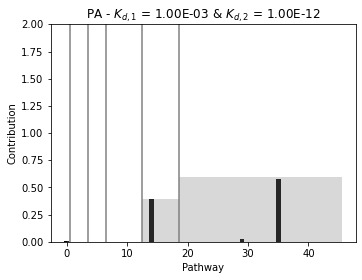

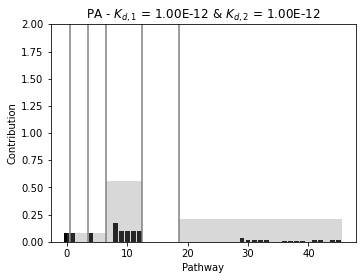

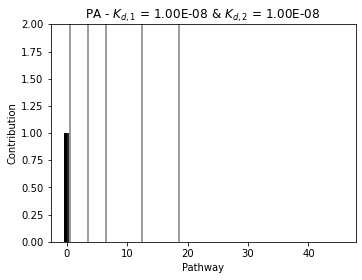

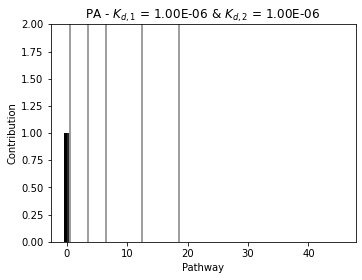

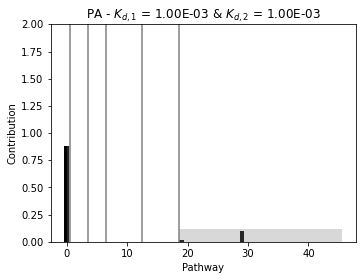

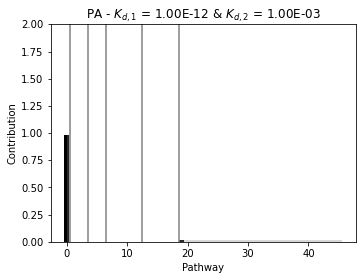

In [51]:
# ---------------------------------------------------
# --- Driver code ---
# --------------------------------------------------- 
print("Working on pathway analysis WITH synth/deg...")
# Need to calculate the species concentrations at the end of 24hrs
# --- parameters to initialize ---

# --- PARAMETERS ---
# List of fixed parameters
kOn = 10**6
# List of parameters that will be explored 
IC_1 = 4*10**-6;
δ = 0 # degradation rate parameter
Q = 0 # synthesis rate parameter
#δ = 2.8*10**-4; Q = δ*IC_1 

tEnd=4; tPts=20000; # 8.6400×10^4
# lists of kd1 and kd2 
kd1 = 10**-12; kd2= 10**-3
#allKdPairs = [[10**-3, 10**-12],[10**-12,10**-12]] # for debugging
allKdPairs = [[10**-3, 10**-12],[10**-12,10**-12],[10**-8, 10**-8],[10**-6,10**-6], [10**-3, 10**-3],[10**-12,10**-3]]
allKdLabels = ['red', 'green', 'orange', 'magenta', 'blue','purple']

# --- Loop through all the main pairs --- 
for Kd_i in range(0,len(allKdLabels)):
    KdPair=allKdPairs[Kd_i];kd1 = KdPair[0]; kd2 = KdPair[1]
    label_kds = allKdLabels[Kd_i]
    # --- ode soln ---
    t = 10**np.linspace(-3,tEnd,tPts); states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
    # Now, integrate the ODEs and put the results in \"solution\" 
    solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)
    print("ODE slns done for "+label_kds+" plot ")

    # ---------------------------------------------------
    # --- Pathway contributions ---
    # --------------------------------------------------- 
    pathwayComp = getPathways(solution_1); listOfPathways=pathwayComp[0];totalFluxes=pathwayComp[1];listOfAllRxns=pathwayComp[2]

    # --- calculate pathway contributions ---
    contributionsAll= calcPathContribution(listOfPathways,totalFluxes,listOfAllRxns)
    pathContNORM = sum(contributionsAll); normPathContri = contributionsAll/pathContNORM
    numPaths=46; pths = [str(x) for x in range(numPaths)]
    # print("Pathway contributions calculated!")

    # --- calculate the sum between final-step pathways ---
    cutOffLines = [1,4, 7, 13, 19];groupIDs = [[0,0.5],[1,4],[4,7],[7,13],[13,19],[19,46]];
    widths=[];
    for pair in groupIDs:
        diffW = abs(pair[1]-pair[0]);widths.append(diffW)
    group1 = normPathContri[0]; group2=normPathContri[1:4]; group3 = normPathContri[4:7]; 
    group4=normPathContri[7:13]; group5=normPathContri[13:19]; group6=normPathContri[19:46];
    # - calc sums - 
    sumG1 = np.sum(group1); sumG2 = sum(group2); sumG3 = sum(group3);sumG4 = sum(group4);sumG5 = sum(group5);sumG6 = sum(group6)
    sumArray = [sumG1,sumG2,sumG3,sumG4,sumG5,sumG6]

    # --- plot pathway contributions ---
    kd1_format_1 = format(kd1,'.2E');kd2_format_1 = format(kd2,'.2E')
    # - Add in gray lines for cutoffs between final step of pathway
    grayLines=cutOffLines;
    plt.figure()
    ax=plt.bar(pths, normPathContri, color = 'black')
    for line in grayLines:
        plt.axvline(line-0.5, 0, 1, color='gray',linestyle='solid')
    # - plot the sums over the correct regions
    y = [0,0.5, 3.5, 6.5, 12.5, 18.5];h = sumArray;w = widths; 
    plt.bar(y,height = h, width = w,align='edge', alpha=0.3, color = 'gray')
    plt.xlabel("Pathway"); plt.ylabel("Contribution")
    plt.title(("PA - $K_{d,1}$ = " + kd1_format_1 + " & $K_{d,2}$ = "+ kd2_format_1) )
    plt.xticks(np.arange(0, len(pths)+1, 10))
    plt.ylim([0, 2])
    #plt.gca().set_aspect('auto')
    #ax.set_aspect('equal')
    #axes_aspect=16.0/12.0
    axes_aspect=18
    axes=plt.gca(); axes.set_aspect(axes_aspect) #18 is the closest I could get :( Idk why
    #plt.show()
    # --- save final plot --- 
    #plt.savefig('SR_PathAnalysis_NoSynthDeg_002_red_'+today+'.eps'); print("Plot saved!") 
    plt.savefig('SR_PathAnalysis_NOSynthDeg_001_'+label_kds+'_'+today+'.pdf'); print("Plot saved!") # transparency not supported in EPS

print("All done!")